In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "compile", "vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
        # categorical variable
        #if tuxdata[col].dtype == 'object':
        #    try:
        #        tuxdata[col] = tuxdata[col].astype('category')
        #    except:
        #        print('Column', ' ', col, ' cannot be converted to category.')
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))

# maybe we can drop options with only one unique value (no interest for machine learning)
#rawtuxdata.drop(columns=ftuniques,inplace=True)

print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))

print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()


    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1150,2722,6015,6026,7676,7726,10442) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (5787, 12798)
Number of options with only one value (eg always y): (3316, 1)
Non tri-state value options (eg string or integer or hybrid values): (156, 1) 
Predictor variables: 12642


In [2]:
rawtuxdata[rawtuxdata['vmlinux'] == 1168072][['cid', 'CC_OPTIMIZE_FOR_SIZE']]

,cid,CC_OPTIMIZE_FOR_SIZE
5783,56589,y
5784,56590,y
5785,56591,y


In [3]:
rawtuxdata[rawtuxdata['vmlinux'] == -1]

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
15,50525,2018-06-15 03:53:45,312.314,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,y,n,y,n,y,n
32,50542,2018-06-15 03:56:16,468.914,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,y,n,n,y,n,m,n
69,50579,2018-06-15 04:00:35,468.916,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,y,n,n,n,n,n
72,50582,2018-06-15 04:01:04,343.571,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,n,n,m,y,n,n,n
76,50586,2018-06-15 04:01:22,558.079,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,n,n,n,m,n,m,y
86,50596,2018-06-15 04:02:50,275.115,-1,-1,-1,-1,-1,-1,-1,...,y,n,y,y,n,n,y,y,n,n
103,50613,2018-06-15 04:04:29,284.565,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,y,n,n,y,n,m,n
126,50636,2018-06-15 04:07:46,333.128,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,y,n,n,n
145,50655,2018-06-15 04:10:35,509.338,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,y,n,y,n
168,50678,2018-06-15 04:12:55,415.854,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,n,n,y,n,n,n


In [4]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]['vmlinux']
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

0      28236896
1      35342744
2      34624152
3      38339072
4      41650560
5      25481312
6      50641216
7     149856048
8     100119848
9     132791616
10     36001168
11     52191240
12     20233544
13     40490904
14     51638552
15           -1
16     24340416
17     20962704
18    142159824
19    122013008
Name: vmlinux, dtype: int64

In [5]:
rawtuxdata.shape, rawtuxdata[rawtuxdata['vmlinux'] != -1].shape, 

((5787, 12798), (5427, 12798))

In [6]:
from sklearn.preprocessing import *

compilation_status_column_name = 'compile_success'

def encode_data_compilation(rawtuxdata):
    lae = LabelEncoder()
    # we save quantitative values we want (here vmlinux, TODO: generalize)
    # the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
    # vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
    o_sizes = rawtuxdata[size_methods]

    # we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
    #tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    tuxdata_for_compilation = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(lae.fit_transform)

    #tuxdata['vmlinux'] = vml 
    tuxdata_for_compilation[size_methods] = o_sizes
    tuxdata_for_compilation[compilation_status_column_name] = rawtuxdata['vmlinux'] != -1
    return tuxdata_for_compilation

tuxdata_for_compilation = encode_data_compilation(rawtuxdata)
tuxdata_for_compilation [compilation_status_column_name].describe()

count     5787
unique       2
top       True
freq      5427
Name: compile_success, dtype: object

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


TESTING_SIZE=0.3 


X_train, X_test, y_train, y_test = train_test_split(tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name), tuxdata_for_compilation[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
clf = GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]    

TOP_FT_IMPORTANCE=20
print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
for f in range(TOP_FT_IMPORTANCE): # len(indices)
    print("%d. feature %s %d (%f)" % (f + 1, tuxdata_for_compilation.columns[indices[f]], indices[f], importances[indices[f]]))

acc = accuracy_score (y_test, y_pred)
prec = precision_score (y_test, y_pred)
reca = recall_score (y_test, y_pred)
f1 = f1_score (y_test, y_pred)
print("Accuracy score: %.2f" % (acc))
print("Precision score: %.2f" % (prec))
print("Recall score: %.2f" % (reca))
print("F1 score: %.2f" % (f1))

Feature ranking: top (20)
1. feature DRM_VBOXVIDEO 8017 (0.223419)
2. feature AIC79XX_BUILD_FIRMWARE 2542 (0.197597)
3. feature AIC7XXX_BUILD_FIRMWARE 1794 (0.139914)
4. feature WANXL_BUILD_FIRMWARE 10526 (0.098079)
5. feature GENERIC_ALLOCATOR 11927 (0.052885)
6. feature SND_SE6X 11730 (0.017817)
7. feature VIDEO_STK1160_COMMON 11379 (0.014860)
8. feature VIDEO_STK1160 11388 (0.014008)
9. feature 9P_FS_POSIX_ACL 3068 (0.011698)
10. feature SOC_CAMERA_OV9640 10205 (0.011012)
11. feature SECURITYFS 4527 (0.009508)
12. feature CIFS_DEBUG_DUMP_KEYS 2695 (0.008542)
13. feature MTD_NAND_DENALI 8954 (0.008171)
14. feature HAVE_INTEL_TXT 638 (0.008147)
15. feature XILINX_PR_DECOUPLER 2109 (0.008111)
16. feature FUSION_LAN 3923 (0.007155)
17. feature ACORN_PARTITION_POWERTEC 2384 (0.006852)
18. feature USB_EHCI_HCD_PLATFORM 9952 (0.006803)
19. feature ROMFS_BACKED_BY_MTD 11950 (0.006247)
20. feature NET_VENDOR_ROCKER 1257 (0.006155)
Accuracy score: 1.00
Precision score: 1.00
Recall score: 1.00

In [8]:
# remove entries with same configurations
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
n_failures = len(rawtuxdata[rawtuxdata['vmlinux'] == -1]) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
print(str(n_failures) + " failures out of " + str(len(rawtuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
rawtuxdata = rawtuxdata[rawtuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
print(str(len(rawtuxdata)) + " after the removal of configurations that do NOT compile")

#tuxdata["vmlinux"]
#tuxdata.where(tuxdata["vmlinux"] == np.NaN)

#tuxdata[tuxdata["vmlinux"] != -1]
#tuxdata
#tuxdata[tuxdata['vmlinux'] != -1].shape

5787 before the removal of some entries (those with same configurations)
5787 after the removal of some entries (those with same configurations)
360 failures out of 5787
5427 after the removal of configurations that do NOT compile


<Figure size 432x288 with 0 Axes>

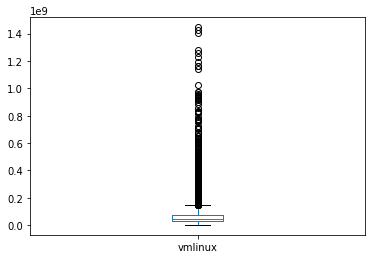

<Figure size 432x288 with 0 Axes>

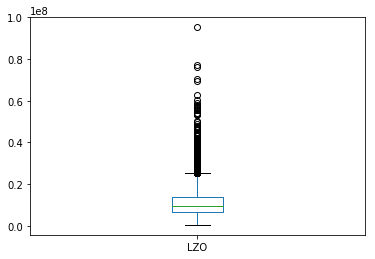

<Figure size 432x288 with 0 Axes>

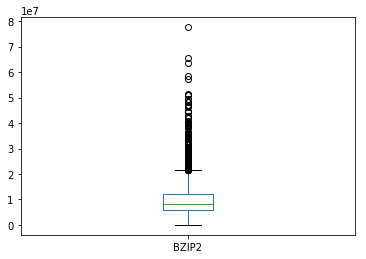

count    5.427000e+03
mean     7.711406e+07
std      1.103948e+08
min      1.168072e+06
25%      2.936172e+07
50%      4.528551e+07
75%      7.712814e+07
max      1.446812e+09
Name: vmlinux, dtype: float64

In [9]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show()

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show()

plt.figure()
pd.DataFrame(rawtuxdata['BZIP2']).plot.box()
plt.show()


rawtuxdata['vmlinux'].describe()


In [10]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

#(rawtuxdata["XZ-vmlinux"] - rawtuxdata["BZIP2-vmlinux"]).plot.box()
# n_size_methods = len(size_methods)
#corr_sizes = [[0 for x in range(n_size_methods)] for y in range(n_size_methods)]
#i = 0
#j = 0
#for size_method in size_methods:
#    csize = rawtuxdata[size_method]   
#    for osize_method in size_methods:
#        if size_method != osize_method:
#            osize = rawtuxdata[osize_method]           
#            pcorr = scipy.stats.pearsonr(csize, osize)[0]
#            corr_sizes[i][j] = pcorr
#        j = j + 1
#    i = i + 1

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,2.91053,25.2021,39.4944,-10.3445,-16.5106
BZIP2o,-2.74237,0,21.768,35.623,-12.8473,-18.8615
LZMAo,-20.0555,-17.7314,0,11.4208,-28.2949,-33.2102
XZo,-154288,-154286,-154270,0,-35.4125,-39.8409
LZOo,-294659,-294656,-294631,55.7607,0,-6.90644
LZ4o,-321754,-321751,-321724,67.4465,7.43784,0


In [11]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-30.7856,24.7857,38.4884,-9.98559,-16.187
BZIP2o,48.7486,0,85.0243,104.95,33.9778,24.7978
LZMAo,-19.7875,-44.6542,0,10.989,-27.7583,-32.7193
XZo,-27.4605,-50.0255,-9.56302,0,-34.6857,-39.1728
LZOo,11.184,-22.9952,38.8201,54.0308,0,-6.91864
LZ4o,19.508,-17.1934,49.2549,65.6042,7.45104,0


In [12]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-25.9595,19.194,29.0309,-8.21073,-13.4625
BZIP2o,36.956,0,62.6178,75.7343,25.8679,18.7626
LZMAo,-15.9769,-38.0253,0,8.22338,-22.8221,-27.21
XZo,-22.1606,-42.6813,-7.38753,0,-28.4984,-32.5581
LZOo,9.01745,-19.1827,30.0417,40.7783,0,-5.75145
LZ4o,15.732,-14.1341,38.1122,49.5251,6.1226,0


In [13]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.454416,0.45442,0.450084,0.468298,0.468252,0.464772,0.446404,0.446393,0.440675,0.453428,0.45342,0.452139,0.466812,0.468092,0.467377,0.471984,0.473381,0.472756
GZIP-bzImage,0.454416,1,0.999961,0.999311,0.997045,0.996397,0.996732,0.997882,0.997786,0.997162,0.994123,0.994038,0.994082,0.997333,0.997502,0.997651,0.994666,0.994867,0.995047
GZIP-vmlinux,0.45442,0.999961,1,0.999267,0.997174,0.996607,0.996698,0.997865,0.997873,0.997138,0.994093,0.994119,0.994044,0.997291,0.997527,0.997604,0.99462,0.994883,0.994997
GZIP,0.450084,0.999311,0.999267,1,0.996451,0.995796,0.997247,0.996804,0.996702,0.997933,0.993883,0.99379,0.993875,0.99726,0.99691,0.997084,0.994565,0.994203,0.994405
BZIP2-bzImage,0.468298,0.997045,0.997174,0.996451,1,0.999541,0.99939,0.994413,0.994543,0.993819,0.992065,0.99222,0.991752,0.998125,0.998331,0.99817,0.997266,0.997481,0.99738
BZIP2-vmlinux,0.468252,0.996397,0.996607,0.995796,0.999541,1,0.998759,0.993785,0.994022,0.99318,0.991469,0.991739,0.991145,0.997492,0.997768,0.997531,0.996638,0.996917,0.996747
BZIP2,0.464772,0.996732,0.996698,0.997247,0.99939,0.998759,1,0.993753,0.993663,0.994645,0.992094,0.992014,0.991827,0.998283,0.997939,0.997949,0.9974,0.997041,0.997095
LZMA-bzImage,0.446404,0.997882,0.997865,0.996804,0.994413,0.993785,0.993753,1,0.99993,0.998759,0.994013,0.993957,0.99401,0.992004,0.992351,0.992503,0.987961,0.988352,0.988533
LZMA-vmlinux,0.446393,0.997786,0.997873,0.996702,0.994543,0.994022,0.993663,0.99993,1,0.998681,0.993928,0.994021,0.993915,0.991906,0.992343,0.992398,0.987859,0.988332,0.988425
LZMA,0.440675,0.997162,0.997138,0.997933,0.993819,0.99318,0.994645,0.998759,0.998681,1,0.993896,0.993829,0.993938,0.992108,0.991759,0.991943,0.988026,0.987661,0.987872


In [14]:
#from category_encoders import *
from sklearn.preprocessing import *

#X = [['y', 1], ['n', 3], ['m', 2]]
#enc.fit(X)
#enc.transform(tuxdata)

#enc = OrdinalEncoder().fit(tuxdata[:10])

# transform the dataset
#enc.transform(tuxdata[:10])

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
#print(non_tristate_options)

# we save quantitative values we want (here vmlinux, TODO: generalize)
# the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
# vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
tuxdata[size_methods] = vml
# tuxdata['vmlinux'].astype('int64')

# example: DEBUG_INFO is either y or n
tuxdata['DEBUG_INFO'].unique()

array([0, 1])

In [15]:
# tuxdata.where(not np.isnan(tuxdata["vmlinux"]))
#tuxdata["vmlinux"][16] == np.isnan
#vml == -1 
#tuxdata["vmlinux"] == -1
#tuxdata['vmlinux'].dtypes
#vml.dtypes
#tuxdata['vmlinux'].dtypes #.astype('int64')
#TODO: remove configurations like this 
#tuxdata[tuxdata['X86_64'] == 'n']
tuxdata['X86_64'].describe()

count    5427.000000
mean        0.999263
std         0.027141
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: X86_64, dtype: float64

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm


TESTING_SIZE=0.3 

# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

linearRegression=False
size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 

X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_of_interest], test_size=TESTING_SIZE, random_state=0)  
# multi output
#X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_methods], test_size=TESTING_SIZE, random_state=0)  

# train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

#clf = RandomForestRegressor(n_estimators=100) 

if linearRegression:
    regr =  linear_model.Lasso() # svm.SVC(kernel='linear') # linear_model.Ridge(alpha=.1) #  # linear_model.Lasso() # linear_model.SGDRegressor() #LinearRegression() # SGDRegressor or linear_model.Lasso()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
else:
    clf = GradientBoostingRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
    # 
    #clf = Pipeline([
    #  ('feature_selection', SelectFromModel(LassoCV(tol = 0.001))),
    #  ('regression', GradientBoostingRegressor(n_estimators=100))
    # ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=100
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances for size of vmlinux")
#plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
#plt.xticks(range(tuxdata.shape[1]), indices)
#plt.xlim([-1, tuxdata.shape[1]])
#plt.show()
mae = mean_absolute_error (y_test, y_pred)# , multioutput='raw_values')
mse = mean_squared_error (y_test, y_pred) #, multioutput='raw_values') 
r2 = r2_score (y_test, y_pred) #, multioutput='raw_values') 
print("Prediction score (MAE): %.2f" % (mae))
print("Prediction score (MSE): %.2f" % (mse))
print("Prediction score (R2): %.2f" % (r2))


Feature ranking: top (100)
1. feature DEBUG_INFO 5697 (0.156715)
2. feature DEBUG_INFO_SPLIT 7210 (0.089875)
3. feature DEBUG_INFO_REDUCED 7183 (0.068248)
4. feature UBSAN_SANITIZE_ALL 2726 (0.030060)
5. feature X86_NEED_RELOCS 5908 (0.027160)
6. feature RANDOMIZE_BASE 5901 (0.020366)
7. feature DEBUG_INFO_DWARF4 7236 (0.017608)
8. feature GCOV_PROFILE_ALL 12583 (0.016842)
9. feature GDB_SCRIPTS 7263 (0.014736)
10. feature RANDOMIZE_MEMORY 5939 (0.011845)
11. feature EFI_MIXED 5245 (0.011356)
12. feature RAPIDIO_ENUM_BASIC 11721 (0.011088)
13. feature UBSAN_ALIGNMENT 2733 (0.010879)
14. feature KASAN 624 (0.010317)
15. feature KASAN_OUTLINE 7932 (0.009819)
16. feature INFINIBAND_USER_ACCESS 9017 (0.007779)
17. feature DVB_TTUSB_BUDGET 3941 (0.006934)
18. feature DRM_I915_DEBUG_GEM 5491 (0.006821)
19. feature STRICT_MODULE_RWX 12548 (0.006775)
20. feature MAXSMP 11186 (0.006059)
21. feature FB_TFT_ILI9163 5139 (0.005957)
22. feature DRM_QXL 8759 (0.005395)
23. feature DRM_VMWGFX 6768 (0

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True)
tuxdata_reduced = model.transform(tuxdata.drop(columns=size_methods))
tuxdata_reduced.shape, tuxdata.shape


((5427, 288), (5427, 12642))

In [18]:
#lass = SelectFromModel(LassoCV(tol = 0.001))
#lass.fit(X_train, y_train)
#tuxdata_reduced_lass = lass.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_lass.shape, tuxdata.shape 

In [19]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True

In [20]:
# tuxdata.where(tuxdata["vmlinux"] != -1).sort_values(by='vmlinux')[:5] # & 

In [21]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    

In [22]:
#provisoire = pd.read_csv(open('provisoire.csv', "r"))

In [23]:
#provisoire[['cid','CC_OPTIMIZE_FOR_SIZE']]

In [24]:
#rawtuxdata.columns[6015] #Columns (1150,6015,6026,7676,7726)

In [25]:
with open("config_bdd.csv", "r") as file:
    k = file.readline()
    t = k.split(",")
    s = set(t)
    print("t:", len(t), "  s:", len(s))

t: 12798   s: 12798
